# FFNN for Multiclass DICOM CT Scan Classification

Includes:
- DICOM loading from structured folders
- Exclusion of True Benign (TB)
- Image augmentation
- Multiclass FFNN

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
import seaborn as sns

from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam, SGD

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

from joblib import Parallel
import multiprocessing
import SimpleITK as sitk

#Code from existing github repo provided by UC Irvine dataset
from utils.equalizer import histEq




# Load Data

In [64]:
# Load in images to X and labels as Y
X_train_input = np.load("../final_project/preprocessed_data/combined_tampered_scans_dataset_train.npy")
Y_train_input = np.load("../final_project/preprocessed_data/combined_tampered_scans_dataset_train_labels.npy")

X_test_input = np.load("../final_project/preprocessed_data/combined_tampered_scans_dataset_test.npy")
Y_test_input = np.load("../final_project/preprocessed_data/combined_tampered_scans_dataset_test_labels.npy")

X_val_input = np.load("../final_project/preprocessed_data/combined_tampered_scans_dataset_val.npy")
Y_val_input = np.load("../final_project/preprocessed_data/combined_tampered_scans_dataset_val_labels.npy")

# Grab middle slices for each split (index 16 from axis 1)
X_train_mid = X_train_input[:, 16, :, :]
X_val_mid   = X_val_input[:, 16, :, :]
X_test_mid  = X_test_input[:, 16, :, :]

# If using FFNN, flatten them
X_train = X_train_mid.reshape(X_train_mid.shape[0], -1)
X_val   = X_val_mid.reshape(X_val_mid.shape[0], -1)
X_test  = X_test_mid.reshape(X_test_mid.shape[0], -1)

# Encode labels
label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(Y_train_input)
Y_val   = label_encoder.transform(Y_val_input)
Y_test  = label_encoder.transform(Y_test_input)

# Print Shapes
print(f'Shape of training dataset: {X_train.shape}, {Y_train.shape}')
print(f'Shape of validation dataset: {X_val.shape}, {Y_val.shape}')
print(f'Shape of test dataset: {X_test.shape}, {Y_test.shape}')

# Print labels
print(label_encoder.classes_)
print(X_train_input.shape)
print(X_train_mid.shape)
print(X_train.shape)

Shape of training dataset: (970, 1024), (970,)
Shape of validation dataset: (33, 1024), (33,)
Shape of test dataset: (33, 1024), (33,)
['FB' 'FM' 'TB' 'TM']
(970, 32, 32, 32)
(970, 32, 32)
(970, 1024)


# Add Class Weights and Check Stats

In [65]:
# Add Class weights to balance out the distribution
raw_labels = np.array(Y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(raw_labels), y=raw_labels)
class_weight_dict = dict(enumerate(class_weights))


print("Class Weights:", class_weight_dict)
print(type(class_weight_dict))

Class Weights: {0: 0.5511363636363636, 1: 1.0104166666666667, 2: 2.6944444444444446, 3: 1.2125}
<class 'dict'>


In [66]:
# Check shapes before running in the FFNN model
print(X_train.shape)  # should be (x, 1024)
print(X_test.shape)
print(Y_train.shape)  # should be (x,)
print(np.unique(Y_train))  # should be [0 1 2 3]
print(class_weight_dict) # should look like: {0: ..., 1: ..., 2: ..., 3: .....}


(970, 1024)
(33, 1024)
(970,)
[0 1 2 3]
{0: 0.5511363636363636, 1: 1.0104166666666667, 2: 2.6944444444444446, 3: 1.2125}


# Build Models

## [128 models]

In [ ]:
# Build tanh SGD
model = models.Sequential()
model.add(layers.Dense(128, activation='tanh', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))

model.compile(
    optimizer=SGD(0.01),
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy',
    ]
)

model.summary()

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict
)

# Build relu SGD
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))

model.compile(
    optimizer=SGD(0.01),
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy',
    ]
)

model.summary()

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict
)

# Build relu Adam
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))

model.compile(
    optimizer=Adam(0.01),
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy',
    ]
)

model.summary()

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict
)

/home/geon0514/anaconda3/envs/py3jp/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_39 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,716 (514.52 KB)

 Trainable params: 131,716 (514.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3974 - loss: 1.6309 - val_accuracy: 0.3939 - val_loss: 1.1307
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5863 - loss: 0.8221 - val_accuracy: 0.5758 - val_loss: 0.9661
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6687 - loss: 0.6767 - val_accuracy: 0.8182 - val_loss: 0.7104
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7343 - loss: 0.5070 - val_accuracy: 0.6667 - val_loss: 0.8087
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7530 - loss: 0.4941 - val_accuracy: 0.5455 - val_loss: 1.0939
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7400 - loss: 0.4978 - val_accuracy: 0.6970 - val_loss: 0.8026
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8022 - loss: 0.3964 - val_accuracy: 0.7273 - val_loss: 0.7831
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7878 - loss: 0.4313 - val_accuracy: 0.7576 - val_loss:

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_41 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,716 (514.52 KB)

 Trainable params: 131,716 (514.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4603 - loss: 1.6767 - val_accuracy: 0.7576 - val_loss: 1.5257
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6107 - loss: 1.2858 - val_accuracy: 0.7273 - val_loss: 1.4310
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7118 - loss: 0.7238 - val_accuracy: 0.8182 - val_loss: 0.8065
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7599 - loss: 0.5530 - val_accuracy: 0.8485 - val_loss: 0.8210
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7758 - loss: 0.4716 - val_accuracy: 0.9091 - val_loss: 0.8033
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7865 - loss: 0.5220 - val_accuracy: 0.8788 - val_loss: 0.6638
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8132 - loss: 0.4203 - val_accuracy: 0.8485 - val_loss: 0.7077
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8229 - loss: 0.4176 - val_accuracy: 0.8485 - val_loss:

## [256, 128 Models]

In [68]:
# Build relu model
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))

# 0.01
model.compile(
    optimizer=Adam(0.01),
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy',
    ]
)

model.summary()

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict
)


# 0.001
model.compile(
    optimizer=Adam(0.001),
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy',
    ]
)

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict
)


# 0.0001
model.compile(
    optimizer=Adam(0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy',
    ]
)

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict
)

/home/geon0514/anaconda3/envs/py3jp/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_43 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 295,812 (1.13 MB)

 Trainable params: 295,812 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3898 - loss: 2.4232 - val_accuracy: 0.6061 - val_loss: 1.1608
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5132 - loss: 1.2456 - val_accuracy: 0.7576 - val_loss: 0.9856
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5760 - loss: 0.8925 - val_accuracy: 0.7576 - val_loss: 0.8102
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6079 - loss: 0.8696 - val_accuracy: 0.7273 - val_loss: 0.9139
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6270 - loss: 0.8592 - val_accuracy: 0.5455 - val_loss: 0.9281
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6161 - loss: 0.7829 - val_accuracy: 0.6667 - val_loss: 0.8914
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6762 - loss: 0.8445 - val_accuracy: 0.7273 - val_loss: 0.7662
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7122 - loss: 0.6985 - val_accuracy: 0.8182 - val_loss:

## [512, 256, 128 Models]

In [69]:
# Build relu model
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))

# 0.01
model.compile(
    optimizer=Adam(0.01),
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy',
    ]
)

model.summary()

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict
)


# 0.001
model.compile(
    optimizer=Adam(0.001),
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy',
    ]
)

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict
)


# 0.0001
model.compile(
    optimizer=Adam(0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy',
    ]
)

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict
)

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_46 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 689,540 (2.63 MB)

 Trainable params: 689,540 (2.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3500 - loss: 3.3859 - val_accuracy: 0.6364 - val_loss: 0.9431
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4315 - loss: 1.4703 - val_accuracy: 0.4545 - val_loss: 1.1513
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4325 - loss: 1.2990 - val_accuracy: 0.3939 - val_loss: 1.0455
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4735 - loss: 1.2756 - val_accuracy: 0.6667 - val_loss: 1.0586
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5527 - loss: 1.0694 - val_accuracy: 0.5758 - val_loss: 1.0760
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5861 - loss: 1.0246 - val_accuracy: 0.6970 - val_loss: 0.9690
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6080 - loss: 0.9749 - val_accuracy: 0.6970 - val_loss: 0.8542
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6330 - loss: 0.8839 - val_accuracy: 0.7273 - val_loss:

## [512, 256, 128 Models SGD]

In [70]:
# Build Tanh SGD
model = models.Sequential()
model.add(layers.Dense(512, activation='tanh', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='tanh'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='tanh'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))

model.compile(
    optimizer=SGD(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy',
    ]
)

model.summary()

# Train Tanh SGD
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict
)


# Build Tanh SGD
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))

model.compile(
    optimizer=SGD(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy',
    ]
)

model.summary()

# Train Tanh SGD
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict
)

/home/geon0514/anaconda3/envs/py3jp/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_50 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 689,540 (2.63 MB)

 Trainable params: 689,540 (2.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2324 - loss: 1.7208 - val_accuracy: 0.1515 - val_loss: 1.5681
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2532 - loss: 1.6489 - val_accuracy: 0.1818 - val_loss: 1.5536
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2768 - loss: 1.5850 - val_accuracy: 0.2424 - val_loss: 1.5399
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2568 - loss: 1.7266 - val_accuracy: 0.2424 - val_loss: 1.5270
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2753 - loss: 1.6588 - val_accuracy: 0.2424 - val_loss: 1.5144
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2557 - loss: 1.6481 - val_accuracy: 0.2424 - val_loss: 1.5034
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2668 - loss: 1.6285 - val_accuracy: 0.2121 - val_loss: 1.4918
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2703 - loss: 1.5903 - val_accuracy: 0.2121 - val_loss:

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_54 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 689,540 (2.63 MB)

 Trainable params: 689,540 (2.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2942 - loss: 1.6159 - val_accuracy: 0.3636 - val_loss: 1.3384
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2911 - loss: 1.5047 - val_accuracy: 0.3636 - val_loss: 1.3381
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2766 - loss: 1.5093 - val_accuracy: 0.3636 - val_loss: 1.3379
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2948 - loss: 1.5728 - val_accuracy: 0.3636 - val_loss: 1.3376
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2804 - loss: 1.5244 - val_accuracy: 0.3636 - val_loss: 1.3374
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3058 - loss: 1.5832 - val_accuracy: 0.3636 - val_loss: 1.3371
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2678 - loss: 1.5223 - val_accuracy: 0.3636 - val_loss: 1.3369
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2601 - loss: 1.5393 - val_accuracy: 0.3636 - val_loss:

## [512, 256, 128 Final Model]

In [102]:
# Build Relu Adam
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))

model.compile(
    optimizer=Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy',
    ]
)

model.summary()

# Train Relu Adam
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict
)



/home/geon0514/anaconda3/envs/py3jp/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_82 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 689,540 (2.63 MB)

 Trainable params: 689,540 (2.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2707 - loss: 1.4018 - val_accuracy: 0.4242 - val_loss: 1.3091
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3439 - loss: 1.3033 - val_accuracy: 0.3636 - val_loss: 1.2426
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3646 - loss: 1.2360 - val_accuracy: 0.3636 - val_loss: 1.1827
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3981 - loss: 1.1318 - val_accuracy: 0.5152 - val_loss: 1.1102
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4408 - loss: 1.1009 - val_accuracy: 0.5455 - val_loss: 1.0461
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4742 - loss: 1.0162 - val_accuracy: 0.5152 - val_loss: 1.0025
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4862 - loss: 1.0224 - val_accuracy: 0.5455 - val_loss: 0.9647
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5439 - loss: 0.9226 - val_accuracy: 0.5455 - val_loss:

# Accuracy and Loss Plot

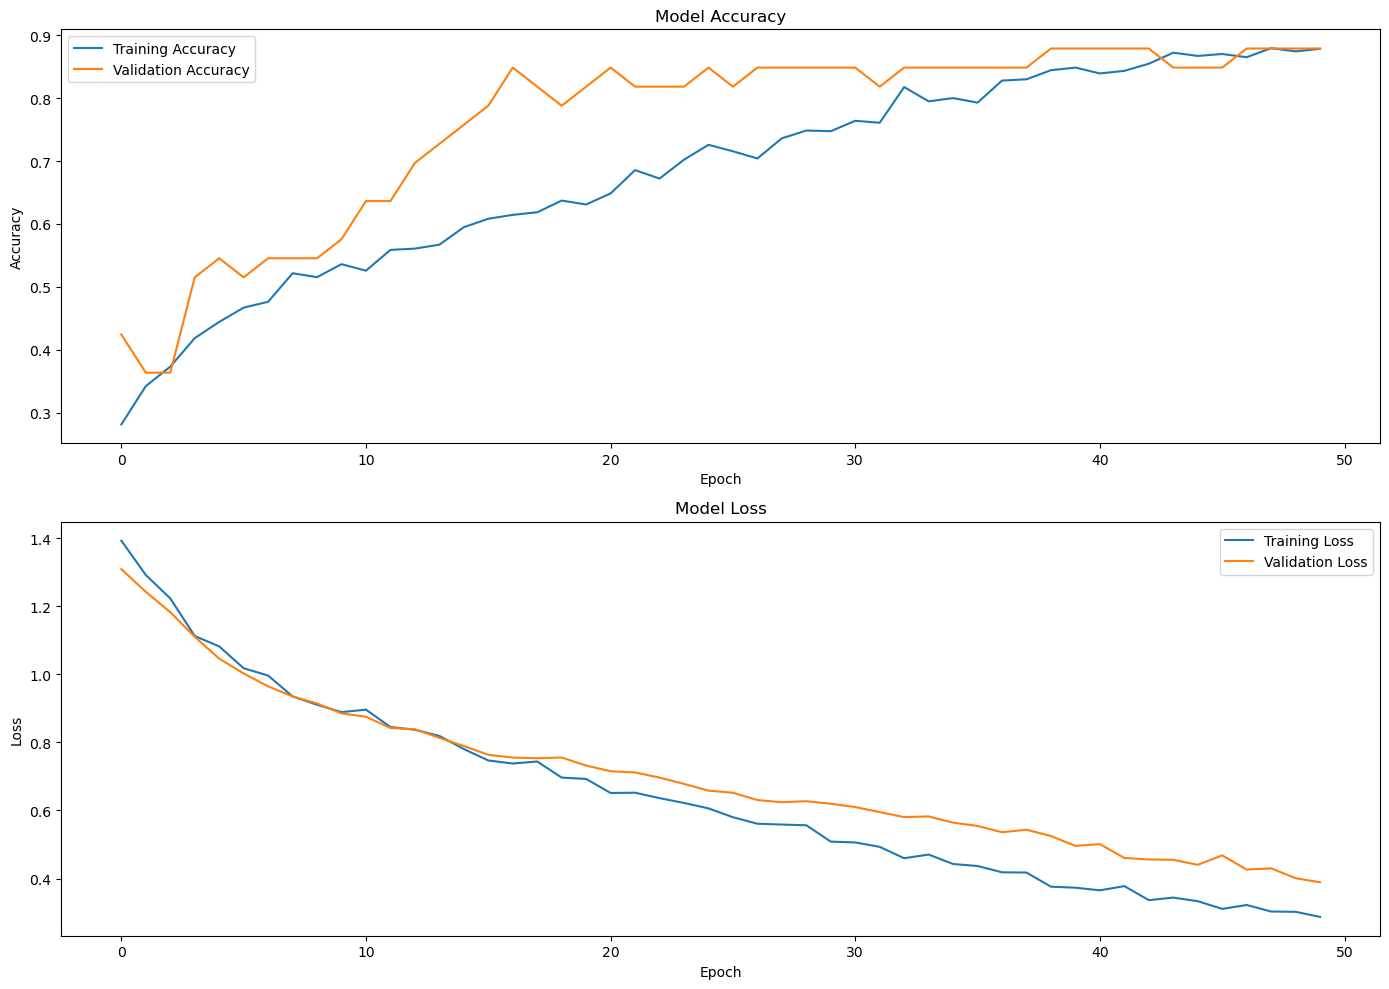

In [103]:
# Plot training history
fig, axs = plt.subplots(2, figsize=(14, 10))

# Accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

# Loss
axs[1].plot(history.history['loss'], label='Training Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('Model Loss') 
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()


plt.tight_layout()
plt.show()


# Final Stats

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Final Training Loss: 0.2872
Final Training Accuracy: 0.8784
Final Validation Loss: 0.3890
Final Validation Accuracy: 0.8788
Final Test Accuracy: 0.6667
              precision    recall  f1-score   support

          FB       0.73      0.79      0.76        14
          FM       0.67      0.75      0.71         8
          TB       1.00      0.33      0.50         3
          TM       0.50      0.50      0.50         8

    accuracy                           0.67        33
   macro avg       0.72      0.59      0.62        33
weighted avg       0.68      0.67      0.66        33



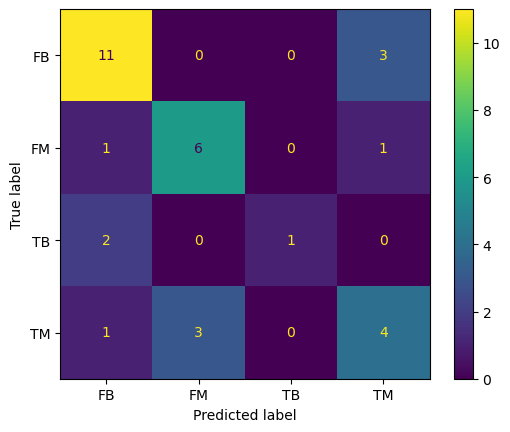

In [ ]:
# Print final training accuracy and loss
final_train_loss = history.history['loss'][-1]
final_train_acc = history.history['accuracy'][-1]

# Print final validation accuracy and loss
final_val_loss = history.history['val_loss'][-1]
final_val_acc = history.history['val_accuracy'][-1]

# Set up the model via the test set
preds = model.predict(X_test)
y_pred = np.argmax(preds, axis=1)
y_true = Y_test

test_acc = accuracy_score(y_true, y_pred)

# Print accuracy
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")

# Print the Precision and Recall
print(classification_report(y_true, y_pred, target_names=["FB", "FM","TB", "TM"]))

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["FB", "FM","TB", "TM"])
disp.plot()
plt.show()